In [ ]:
import os
import glob

# !!! --- IMPORTANT --- !!!
# Replace 'your_file_name.zip' with the name of your zip file
zip_file_name = 'nhanes_data.zip'

# --------------------------

# Remove old XPT files just in case
for f in glob.glob('*.xpt'):
    os.remove(f)
print("Removed old .XPT files.")

# Unzip the new file
if os.path.exists(zip_file_name):
    print(f"Unzipping {zip_file_name}...")
    !unzip -o "{zip_file_name}" -d .
    print("--- Files unzipped successfully! ---")
    !ls *.XPT
else:
    print(f"ERROR: File not found: {zip_file_name}")
    print("Please upload your .zip file and check the name.")

Removed old .XPT files.
Unzipping nhanes_data.zip...
Archive:  nhanes_data.zip
  inflating: ./MERGE_DATA/BMX.xpt    
  inflating: ./MERGE_DATA/BMX_B.xpt  
  inflating: ./MERGE_DATA/BMX_C.xpt  
  inflating: ./MERGE_DATA/BMX_D.xpt  
  inflating: ./MERGE_DATA/BMX_E.xpt  
  inflating: ./MERGE_DATA/BMX_F.xpt  
  inflating: ./MERGE_DATA/BMX_G.xpt  
  inflating: ./MERGE_DATA/BMX_H.xpt  
  inflating: ./MERGE_DATA/BMX_I.xpt  
  inflating: ./MERGE_DATA/BMX_J.xpt  
  inflating: ./MERGE_DATA/BMX_L.xpt  
  inflating: ./MERGE_DATA/BPQ.xpt    
  inflating: ./MERGE_DATA/BPQ_B.xpt  
  inflating: ./MERGE_DATA/BPQ_C.xpt  
  inflating: ./MERGE_DATA/BPQ_D.xpt  
  inflating: ./MERGE_DATA/BPQ_E.xpt  
  inflating: ./MERGE_DATA/BPQ_F.xpt  
  inflating: ./MERGE_DATA/BPQ_G.xpt  
  inflating: ./MERGE_DATA/BPQ_H.xpt  
  inflating: ./MERGE_DATA/BPQ_I.xpt  
  inflating: ./MERGE_DATA/BPQ_L.xpt  
  inflating: ./MERGE_DATA/BPX.xpt    
  inflating: ./MERGE_DATA/BPX_B.xpt  
  inflating: ./MERGE_DATA/BPX_C.xpt  
  inflati

In [ ]:
import pandas as pd
import numpy as np
import glob

# --- This map defines our "standard" names and finds old names ---
# (Standard Name, [List of possible original names])
COMPONENT_VARS = {
    'DEMO': [('SEQN', ['SEQN']), ('Age', ['RIDAGEYR']), ('Gender', ['RIAGENDR'])],
    'DIQ':  [('SEQN', ['SEQN']), ('Diabetes', ['DIQ010']), ('FamilyHistory', ['DIQ175A'])],
    'BMX':  [('SEQN', ['SEQN']), ('BMI', ['BMXBMI'])],
    'BPX':  [('SEQN', ['SEQN']), ('SystolicBP', ['BPXSY1']), ('DiastolicBP', ['BPXDI1'])],
    'GHB':  [('SEQN', ['SEQN']), ('A1c', ['LBXGH'])],
    'GLU':  [('SEQN', ['SEQN']), ('Glucose', ['LBXGLU'])],
    'TCHOL': [('SEQN', ['SEQN']), ('TotalCholesterol', ['LBXTC'])],
    'TRIGLY': [('SEQN', ['SEQN']), ('Triglycerides', ['LBXTR', 'LBDTR'])] # Handles name changes
}

# --- This map finds all the different file names you downloaded ---
# --- [xX][pP][tT] makes the search case-insensitive for the file extension ---
FILE_PATTERNS = {
    'DEMO':   ['DEMO_*.[xX][pP][tT]', 'P_DEMO.[xX][pP][tT]'],
    'DIQ':    ['DIQ_*.[xX][pP][tT]', 'DIQ.[xX][pP][tT]', 'P_DIQ.[xX][pP][tT]'],
    'BMX':    ['BMX_*.[xX][pP][tT]', 'BMX.[xX][pP][tT]', 'P_BMX.[xX][pP][tT]'],
    'BPX':    ['BPX_*.[xX][pP][tT]', 'BPX.[xX][pP][tT]'],
    'GHB':    ['GHB_*.[xX][pP][tT]', 'L10_*.[xX][pP][tT]', 'LAB10.[xX][pP][tT]', 'P_GHB.[xX][pP][tT]'],
    'GLU':    ['GLU_*.[xX][pP][tT]', 'P_GLU.[xX][pP][tT]'], # Glucose wasn't collected in all early cycles
    'TCHOL':  ['TCHOL_*.[xX][pP][tT]', 'P_TCHOL.[xX][pP][tT]', 'LAB13AM.[xX][pP][tT]', 'L13AM_*.[xX][pP][tT]'], # Older files
    'TRIGLY': ['TRIGLY_*.[xX][pP][tT]', 'P_TRIGLY.[xX][pP][tT]', 'LAB13AM.[xX][pP][tT]', 'L13AM_*.[xX][pP][tT]'] # Older files
}

# This will hold our stacked component data (e.g., all DEMO data in one df)
all_component_data = {}

# --- Define the data folder ---
data_folder = './MERGE_DATA/'

print("--- Starting Master Merge Process ---")

# Loop for each component (DEMO, DIQ, BMX, etc.)
for component, var_list in COMPONENT_VARS.items():

    files_for_component = []
    # Find all files that match the patterns for this component
    for pattern in FILE_PATTERNS[component]:
        # Look inside the data_folder
        files_for_component.extend(glob.glob(f'{data_folder}{pattern}'))

    if not files_for_component:
        print(f"Warning: No files found for component '{component}'")
        continue

    print(f"Found {len(files_for_component)} files for {component}...")

    cycle_dfs = [] # A temporary list to hold each cycle's DataFrame

    # Loop for each file in that component
    for file_path in files_for_component:
        try:
            # --- THIS BLOCK IS THE FIX ---

            # 1. Load the ENTIRE file (no 'nrows')
            temp_df = pd.read_sas(file_path, format='xport', encoding='utf-8')
            file_cols = temp_df.columns

            cols_to_load_original = [] # Will hold the original names (e.g., 'LBXGH')
            rename_map = {}            # Will hold {'LBXGH': 'A1c'}

            # 2. Build the rename map and the list of columns to keep
            for standard_name, possible_names in var_list:
                found = False
                for p_name in possible_names:
                    if p_name in file_cols:
                        cols_to_load_original.append(p_name)
                        rename_map[p_name] = standard_name
                        found = True
                        break # Found the right name for this var

                # Special check for Cholesterol/Trig in combined files
                if component in ['TCHOL', 'TRIGLY'] and 'LBXTC' in file_cols and standard_name == 'TotalCholesterol':
                     cols_to_load_original.append('LBXTC')
                     rename_map['LBXTC'] = 'TotalCholesterol'
                if component in ['TCHOL', 'TRIGLY'] and 'LBDTR' in file_cols and standard_name == 'Triglycerides':
                     cols_to_load_original.append('LBDTR')
                     rename_map['LBDTR'] = 'Triglycerides'

            # 3. Create the final df by subsetting and renaming
            # Use set() to remove duplicates from cols_to_load_original
            final_cols_to_load = list(set(cols_to_load_original))

            df_cycle = temp_df[final_cols_to_load] # Subset the full df
            df_cycle = df_cycle.rename(columns=rename_map) # Rename the columns
            cycle_dfs.append(df_cycle)

            # --- END OF FIX ---

        except Exception as e:
            # This will catch any other errors, like with the 'DIQ_L (1).xpt' file
            print(f"  > ERROR loading {file_path}: {e}")

    # 4. Concat all cycles (e.g., stack 2018, 2016, 2014) for this component
    if cycle_dfs:
        all_component_data[component] = pd.concat(cycle_dfs, ignore_index=True)
        print(f"  > Successfully loaded and stacked {component} data.")

# --- Final Merge: Combine all components ---
print("\n--- Merging all components together... ---")

# Start with the DEMO data
if 'DEMO' not in all_component_data:
    print("FATAL ERROR: No DEMO data was loaded. Cannot proceed.")
else:
    df_merged = all_component_data['DEMO'].copy()

    # Merge all other components onto it
    for name, df in all_component_data.items():
        if name == 'DEMO':
            continue # Skip, it's our base

        # Drop duplicate SEQN rows from the component df
        df = df.drop_duplicates(subset=['SEQN'])

        df_merged = pd.merge(df_merged, df, on='SEQN', how='left')

    print("\n--- MASTER MERGE COMPLETE! ---")
    print(f"Total Combined Shape: {df_merged.shape}")
    print("Head of final merged data:")
    display(df_merged.head())

--- Starting Master Merge Process ---
Found 11 files for DEMO...
  > Successfully loaded and stacked DEMO data.
Found 10 files for DIQ...
  > Successfully loaded and stacked DIQ data.
Found 12 files for BMX...
  > Successfully loaded and stacked BMX data.
Found 10 files for BPX...
  > Successfully loaded and stacked BPX data.
Found 12 files for GHB...
  > Successfully loaded and stacked GHB data.
Found 5 files for GLU...
  > Successfully loaded and stacked GLU data.
Found 12 files for TCHOL...
  > Successfully loaded and stacked TCHOL data.
Found 12 files for TRIGLY...
  > Successfully loaded and stacked TRIGLY data.

--- Merging all components together... ---

--- MASTER MERGE COMPLETE! ---
Total Combined Shape: (118844, 12)
Head of final merged data:


,SEQN,Age,Gender,Diabetes,FamilyHistory,BMI,DiastolicBP,SystolicBP,A1c,Glucose,TotalCholesterol,Triglycerides
0,51624.0,34.0,1.0,2.0,NaN,32.22,88.0,114.0,5.2,NaN,135.0,NaN
1,51625.0,4.0,1.0,2.0,NaN,15.30,NaN,NaN,NaN,NaN,NaN,NaN
2,51626.0,16.0,1.0,2.0,NaN,22.00,62.0,112.0,5.7,NaN,192.0,NaN
3,51627.0,10.0,1.0,2.0,NaN,18.22,36.0,92.0,NaN,NaN,161.0,NaN
4,51628.0,60.0,2.0,1.0,NaN,42.39,70.0,154.0,6.0,NaN,202.0,NaN


In [ ]:
print("--- Starting Final Cleaning Process ---")

# Make a copy to work on
df_clean = df_merged.copy()

# 1. Create Target Variable (recoding 'Diabetes' column)
# DIQ010: 1.0=Yes, 2.0=No, 3.0=Borderline
print("Cleaning target variable 'Diabetes'...")
df_clean['Diabetes'] = df_clean['Diabetes'].apply(lambda x: 1 if x == 1 else (0 if x == 2 or x == 3 else pd.NA))
df_clean = df_clean.dropna(subset=['Diabetes'])
df_clean['Diabetes'] = df_clean['Diabetes'].astype(int)

# 2. Recode Features
print("Recoding 'Gender' and 'FamilyHistory'...")
# Gender: 1.0=Male, 2.0=Female -> 1=Male, 0=Female
df_clean['Gender'] = df_clean['Gender'].map({1.0: 1, 2.0: 0})

# FamilyHistory (DIQ175A): 10.0=Family History -> 1=Yes, NaN/Other=0
df_clean['FamilyHistory'] = df_clean['FamilyHistory'].apply(lambda x: 1 if x == 10 else 0)

# 3. Impute Missing Data
print("Imputing missing values with medians...")
# Get the full list of features
features = [
    'Age', 'Gender', 'BMI', 'SystolicBP', 'DiastolicBP', 'A1c',
    'Glucose', 'TotalCholesterol', 'Triglycerides', 'FamilyHistory'
]

# Loop through and fill NaNs
for col in features:
    # We only need to impute numerical features that are not our binary flags
    if col not in ['Gender', 'FamilyHistory', 'Diabetes']:
        median_val = df_clean[col].median()
        df_clean[col] = df_clean[col].fillna(median_val)

print("\n--- FINAL CLEANING COMPLETE ---")
print(f"Shape of final cleaned data: {df_clean.shape}")

# --- Save the final dataset to a new file ---
print("\nSaving final dataset to 'diabetes_master_dataset.csv'...")
df_clean.to_csv('diabetes_master_dataset.csv', index=False)

print("All done! You can now download 'diabetes_master_dataset.csv'")

--- Starting Final Cleaning Process ---
Cleaning target variable 'Diabetes'...
Recoding 'Gender' and 'FamilyHistory'...
Imputing missing values with medians...

--- FINAL CLEANING COMPLETE ---
Shape of final cleaned data: (93696, 12)

Saving final dataset to 'diabetes_master_dataset.csv'...
All done! You can now download 'diabetes_master_dataset.csv'


In [ ]:
# Import machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

print("Imported ML libraries.")

### 1. Define your Features (X) and Target (y) ###
# These are the *exact* column names from your df_clean DataFrame
features = [
    'Age',
    'Gender',
    'BMI',
    'SystolicBP',
    'DiastolicBP',
    'A1c',
    'Glucose',
    'TotalCholesterol',
    'Triglycerides',
    'FamilyHistory'
]

# Use the final 'df_clean' variable from the previous step
X = df_clean[features]
y = df_clean['Diabetes']

### 2. Split Data into Training and Testing Sets ###
# We'll train on 80% and test on 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data split into: {X_train.shape[0]} training samples and {X_test.shape[0]} testing samples.")

### 3. Scale the Features ###
# Scale the data based on the *training* set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # Only .transform() on test data!

print("Features have been scaled.")

### 4. Train the Model ###
# Create an instance of the model
model = LogisticRegression(random_state=42)

# "Fit" the model to your new, scaled training data
model.fit(X_train_scaled, y_train)

print("\n--- Model training complete! ---")

Imported ML libraries.
Data split into: 74956 training samples and 18740 testing samples.
Features have been scaled.

--- Model training complete! ---


Making predictions on the new, larger test data...
Model Accuracy: 95.07%

Confusion Matrix:


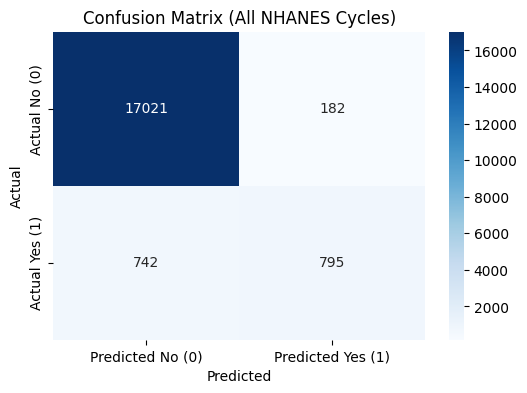


Classification Report (All NHANES Cycles):
                 precision    recall  f1-score   support

No Diabetes (0)       0.96      0.99      0.97     17203
   Diabetes (1)       0.81      0.52      0.63      1537

       accuracy                           0.95     18740
      macro avg       0.89      0.75      0.80     18740
   weighted avg       0.95      0.95      0.95     18740



In [ ]:
# Import the tools for evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print("Making predictions on the new, larger test data...")
# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

### 1. Accuracy Score ###
acc = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {acc * 100:.2f}%")

### 2. Confusion Matrix ###
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No (0)', 'Predicted Yes (1)'],
            yticklabels=['Actual No (0)', 'Actual Yes (1)'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (All NHANES Cycles)')
plt.show()

### 3. Classification Report ###
print("\nClassification Report (All NHANES Cycles):")
print(classification_report(y_test, y_pred, target_names=['No Diabetes (0)', 'Diabetes (1)']))

In [ ]:
%pip install pyreadstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 666.4/666.4 kB 11.6 MB/s eta 0:00:00


In [ ]:
# Import all the models and metrics we'll need
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time

print("--- Starting Model Comparison ---")

# We can re-use the scaled data from Step 5
# X_train_scaled, X_test_scaled, y_train, y_test should all be in memory.

# 1. Define all the models we want to test
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1), # n_jobs=-1 uses all CPU cores
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# 2. Create an empty list to store the results
results_list = []

# 3. Loop through each model, train it, and store the results
for model_name, model in models.items():
    print(f"Training {model_name}...")
    start_time = time.time()

    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test_scaled)
    end_time = time.time()

    # Calculate the key metrics
    # We use 'pos_label=1' to get the scores for the "Diabetes (1)" class
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)

    # Store the results in a dictionary
    model_results = {
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision (1)": precision,
        "Recall (1)": recall,
        "F1-Score (1)": f1,
        "Train Time (s)": end_time - start_time
    }

    # Add this model's results to our list
    results_list.append(model_results)

print("\n--- All models trained and evaluated! ---")

--- Starting Model Comparison ---
Training Logistic Regression...
Training Decision Tree...
Training Random Forest...
Training Gradient Boosting...

--- All models trained and evaluated! ---


--- Model Comparison Results ---


,Model,Accuracy,Precision (1),Recall (1),F1-Score (1),Train Time (s)
2,Random Forest,0.956510,0.801839,0.623943,0.701793,12.197298
3,Gradient Boosting,0.953682,0.774405,0.614183,0.685051,9.580779
1,Decision Tree,0.934152,0.596558,0.608979,0.602704,1.026778
0,Logistic Regression,0.950694,0.813715,0.517241,0.632458,0.354907


/tmp/ipython-input-192648102.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


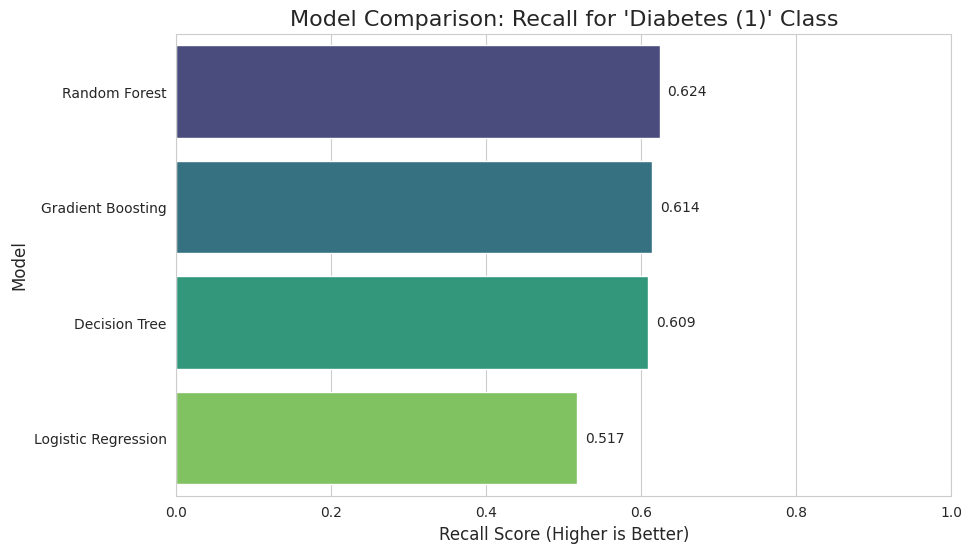

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the list of results into a DataFrame
df_comparison = pd.DataFrame(results_list)

# Sort the results by our most important metric: Recall (1)
df_comparison = df_comparison.sort_values(by="Recall (1)", ascending=False)

# Display the final comparison table
print("--- Model Comparison Results ---")
display(df_comparison)


# --- Plot the results ---

# Set the style
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Create the bar plot
# We plot Recall (1) because it's the most important for "early intervention"
barplot = sns.barplot(
    x="Recall (1)",
    y="Model",
    data=df_comparison,
    palette="viridis"
)

# Add labels to the bars
for p in barplot.patches:
    width = p.get_width()
    plt.text(width + 0.01,  # x coordinate
             p.get_y() + p.get_height() / 2, # y coordinate
             f'{width:.3f}', # The text
             va='center')

plt.title("Model Comparison: Recall for 'Diabetes (1)' Class", fontsize=16)
plt.xlabel("Recall Score (Higher is Better)", fontsize=12)
plt.ylabel("Model", fontsize=12)
plt.xlim(0, 1.0) # Set x-axis limit from 0 to 1
plt.show()